In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
data = pd.read_csv("dataset.csv",sep=';')

In [48]:
feature=['age','job','marital','education','default','loan','campaign','duration','emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed','y']
aim=data[feature].copy()
object_cols = ['job', 'marital', 'education', 'default', 'loan','y']
for col in object_cols:
    aim[col] = LabelEncoder().fit_transform(aim[col])
models={
    "Gaussian Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=10000)
}
X_train,X_test,y_train,y_test = train_test_split(aim.drop(columns='y',axis=1),aim['y'],test_size=0.3,random_state=43)
F1_score={"Before Processing":{
    "Class 0":[],
    "class 1":[]
},
          "After Processing":{
    "Class 0":[],
    "class 1":[]
          }}
class_0=[]
class_1=[]
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    class_0.append(f1_score(y_test, y_pred, pos_label=0))
    class_1.append(f1_score(y_test, y_pred, pos_label=1))

F1_score['Before Processing']["Class 0"]=class_0
F1_score['Before Processing']["Class 1"]=class_1

In [49]:
def find_boxplot_boundaries(
    col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.

    Args:
        col: a pandas serires of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)


In [50]:
data['age'] = BoxplotOutlierClipper(whisker_coeff=1.1).fit_transform(data['age'])
data['duration'] = BoxplotOutlierClipper(whisker_coeff=-5).fit_transform(data['duration'])
pca_attr=['emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']
data_pca=data[pca_attr]
pca = PCA(n_components=2)  # Change number of components if needed
pca_result = pca.fit_transform(data_pca)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
aim.drop(columns=pca_attr,axis=1,inplace=True)
aim['general_economic_1']=pca_df['PC1']
aim['general_economic_2']=pca_df['PC2']
aim.columns

Index(['age', 'job', 'marital', 'education', 'default', 'loan', 'campaign',
       'duration', 'cons.conf.idx', 'y', 'general_economic_1',
       'general_economic_2'],
      dtype='object')

In [51]:
X_train,X_test,y_train,y_test = train_test_split(aim.drop(columns='y',axis=1),aim['y'],test_size=0.3,random_state=43)
results = []
class_0=[]
class_1=[]
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    class_0.append(f1_score(y_test, y_pred, pos_label=0))
    class_1.append(f1_score(y_test, y_pred, pos_label=1))

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (Class 0)": precision_score(y_test, y_pred, pos_label=0),
        "Precision (Class 1)": precision_score(y_test, y_pred, pos_label=1),
        "Recall (Class 0)": recall_score(y_test, y_pred, pos_label=0),
        "Recall (Class 1)": recall_score(y_test, y_pred, pos_label=1),
        "F1 Score (Class 0)": f1_score(y_test, y_pred, pos_label=0),
        "F1 Score (Class 1)": f1_score(y_test, y_pred, pos_label=1),
    })

F1_score['After Processing']["Class 0"]=class_0
F1_score['After Processing']["Class 1"]=class_1
df = pd.DataFrame(results).set_index("Model")


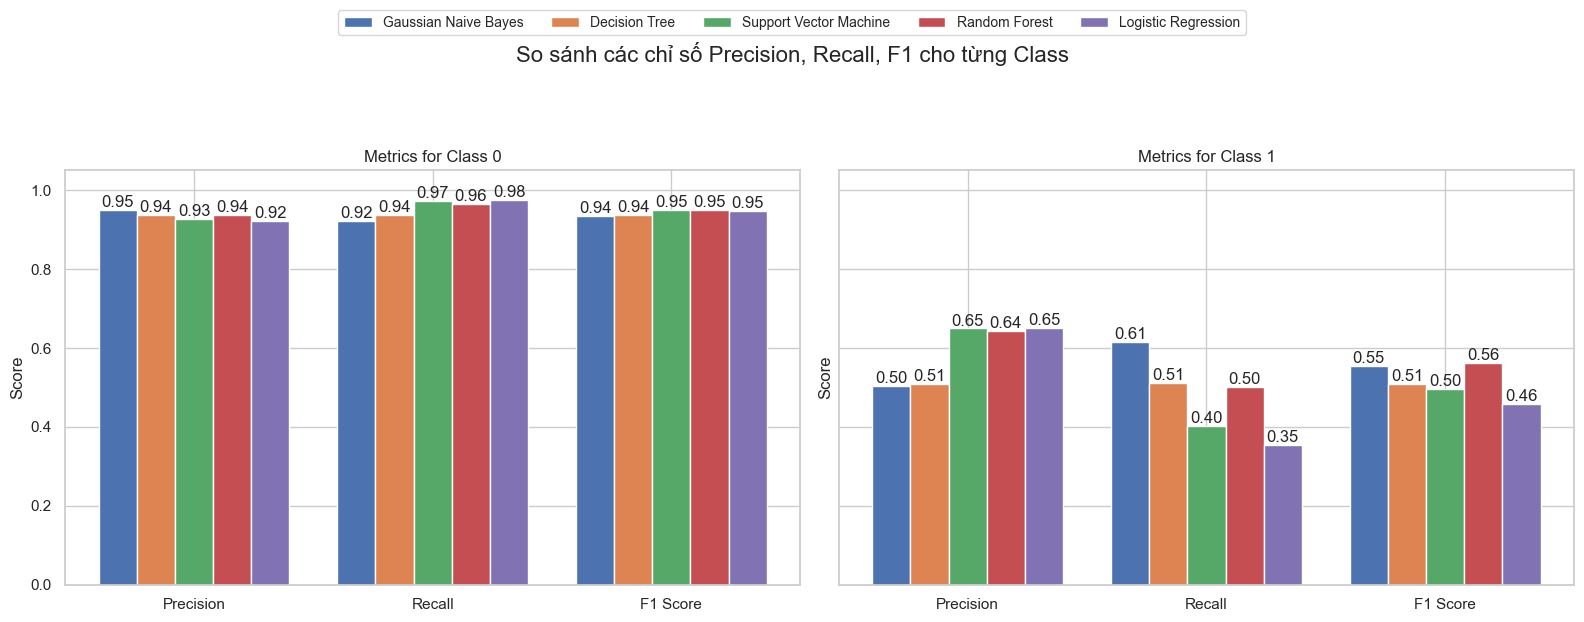

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_per_class_barcharts(df):
    models = df.index.tolist()
    metrics = ["Precision", "Recall", "F1 Score"]
    x = np.arange(len(metrics))
    width = 0.8 / len(models)  # Độ rộng mỗi cột, chia đều cho số model

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    bars = []  # Lưu các bar để thêm nhãn và tạo legend chung
    for idx, class_label in enumerate(["Class 0", "Class 1"]):
        ax = axs[idx]
        for i, model in enumerate(models):
            values = [df.loc[model][f"{m} ({class_label})"] for m in metrics]
            bars.append(ax.bar(x + i * width, values, width=width, label=model if idx == 0 else ""))

        ax.set_xticks(x + width * (len(models) - 1) / 2)
        ax.set_xticklabels(metrics)
        ax.set_ylim(0, 1.05)
        ax.set_title(f"Metrics for {class_label}")
        ax.set_ylabel("Score")

        # Thêm nhãn giá trị trên đỉnh của các cột
        for bar_group in bars[-len(models):]:  # Chỉ áp dụng cho nhóm cột hiện tại
            ax.bar_label(bar_group, fmt='%.2f', label_type='edge')

    # Tạo legend chung cho toàn bộ figure
    fig.legend(handles=bars[:len(models)], labels=models, fontsize='small', loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=5)

    plt.suptitle("So sánh các chỉ số Precision, Recall, F1 cho từng Class", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

# Giả sử df là DataFrame của bạn, bạn cần truyền df vào hàm
# Ví dụ:
# df = ... (dữ liệu của bạn)
plot_per_class_barcharts(df)

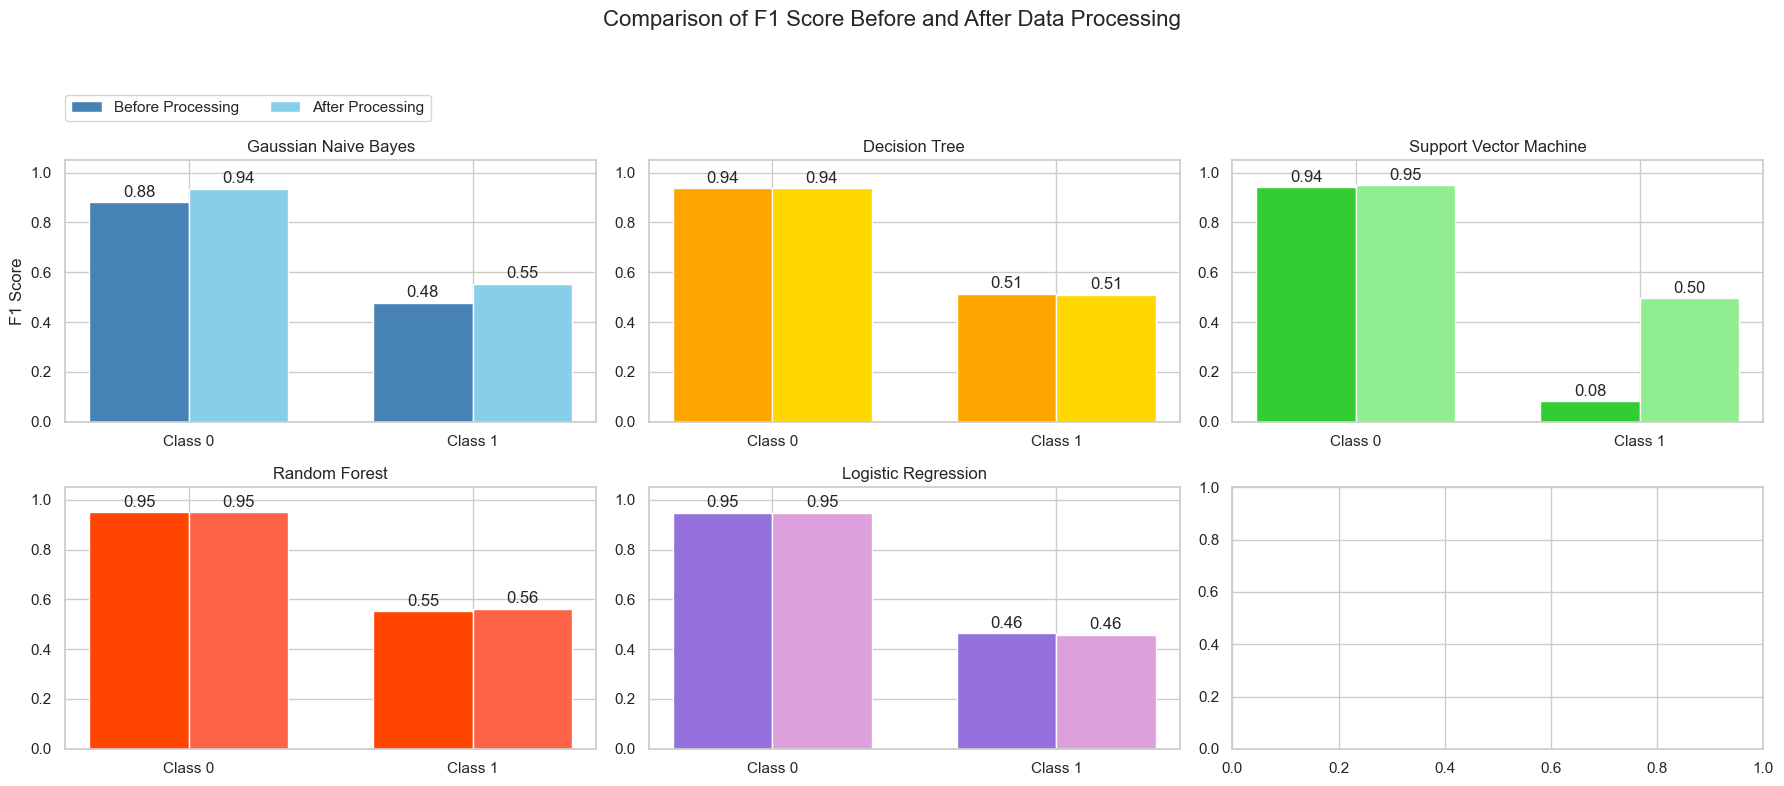

In [55]:
models = ["Gaussian Naive Bayes", "Decision Tree", "Support Vector Machine", "Random Forest", "Logistic Regression"]
# Tạo 5 subplot
fig, axs = plt.subplots(2, 3, figsize=(18, 8), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1, 1]})
axs = axs.flatten()  # Làm phẳng mảng subplot để dễ xử lý

# Vẽ đồ thị cho từng mô hình
for idx, model in enumerate(models):
    ax = axs[idx]
    x = np.arange(2)  # 2 cột cho Class 0 và Class 1
    width = 0.35  # Độ rộng cột

    # Dữ liệu cho Before và After
    before = [F1_score["Before Processing"]["Class 0"][idx], F1_score["Before Processing"]["Class 1"][idx]]
    after = [F1_score["After Processing"]["Class 0"][idx], F1_score["After Processing"]["Class 1"][idx]]

    # Vẽ cột
    ax.bar(x - width/2, before, width, label="Before Processing", color="#4682B4" if idx == 0 else "#FFA500" if idx == 1 else "#32CD32" if idx == 2 else "#FF4500" if idx == 3 else "#9370DB")
    ax.bar(x + width/2, after, width, label="After Processing", color="#87CEEB" if idx == 0 else "#FFD700" if idx == 1 else "#90EE90" if idx == 2 else "#FF6347" if idx == 3 else "#DDA0DD")

    # Thêm nhãn giá trị trên cột
    for i, v in enumerate(before):
        ax.text(i - width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
    for i, v in enumerate(after):
        ax.text(i + width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

    # Cài đặt trục và tiêu đề
    ax.set_xticks(x)
    ax.set_xticklabels(["Class 0", "Class 1"])
    ax.set_ylim(0, 1.05)
    ax.set_title(f"{model}")
    ax.set_ylabel("F1 Score") if idx == 0 else None

    # Thêm legend chung
    if idx == 0:
        ax.legend(loc=(0.5,0.5), bbox_to_anchor=(0, 1.15), ncol=2)

# Điều chỉnh bố cục
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.suptitle("Comparison of F1 Score Before and After Data Processing", fontsize=16)
plt.show()